In [12]:
import pandas as pd
import os
from datetime import datetime
from dataretrieval import nwis
import matplotlib.pyplot as plt

### In this note book we will:
- Extract the flow at the nearest USGS gage from the date of each flowtracker measurement
- Get the proportion of our measured flow to the flow at the USGS gage at the same time
- Apply that proportion to the time period we want to model, to adjust boundary and tributary flows.

In [5]:
#reading in data with relative paths so that it can be used by others who clone repository from github
script_dir = os.getcwd()

#flowtracker Observations
flowtracker_path = os.path.abspath(os.path.join(script_dir, '..', '..', 'observations','FlowTrackerObs', 'FlowtrackerMaster2023.csv'))


#read flowtracker data
flowtracker = pd.read_csv(flowtracker_path)
flowtracker.index = flowtracker['Name']

# July calibration Files
july_hsfiles_path = os.path.abspath(os.path.join(script_dir, '..', '..', 'calibration','July'))



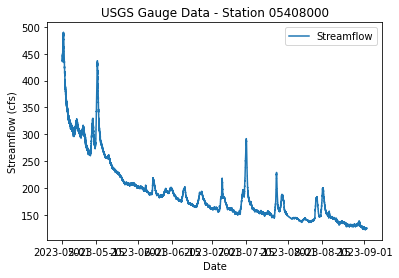

In [6]:

# Specify the USGS gauge station code and the period of interest
station_code = '05408000'  # Replace with the actual code of the gauge station you are interested in
start_date = '2023-05-01'
end_date = '2023-09-01'

# Use the nwis class to retrieve daily streamflow data for the specified station
data = nwis.get_record(sites=station_code, service='iv', start=start_date, end=end_date, parameterCd='00060')
data.index = pd.to_datetime(data.index)
# Plot the streamflow data
plt.plot(data.index, data['00060'], label='Streamflow')
plt.xlabel('Date')
plt.ylabel('Streamflow (cfs)')
plt.title(f'USGS Gauge Data - Station {station_code}')
plt.legend()
plt.show()


### Get the file names for each tributary file and the boundary file, in order to adjust flows

In [7]:
#listing trib files to apply corrections
import os

def get_files(folder_path):
    # Initialize an empty list to store file names
    file_names = []
    
    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        #print(f"Checking file: {filename}")

        # Check if the filename contains 'trib'
        if ('trib' in filename or 'boundary' in filename) and 'accretion' not in filename:
            # Add the filename to the list
            print(f"Adding file: {filename}")

            file_names.append(filename)
    return file_names

# function usage
folder_path = os.path.join(july_hsfiles_path, 'inputs')
file_names = get_files(folder_path)
print(file_names)

Adding file: bloomtrib.csv
Adding file: boydtrib.csv
Adding file: halltrib.csv
Adding file: hayestrib.csv
Adding file: hwy82downtrib.csv
Adding file: hwy82uptrib.csv
Adding file: mayertrib.csv
Adding file: riverrdtrib.csv
Adding file: rockyruntrib.csv
Adding file: seasbranchtrib.csv
Adding file: smarthallowtrib.csv
Adding file: thnorthtrib.csv
Adding file: WFK23_boundary.csv
Adding file: yodertrib.csv
['bloomtrib.csv', 'boydtrib.csv', 'halltrib.csv', 'hayestrib.csv', 'hwy82downtrib.csv', 'hwy82uptrib.csv', 'mayertrib.csv', 'riverrdtrib.csv', 'rockyruntrib.csv', 'seasbranchtrib.csv', 'smarthallowtrib.csv', 'thnorthtrib.csv', 'WFK23_boundary.csv', 'yodertrib.csv']


### Make a dictionary that links the name of each flowtracker measurement with the correspondiing heatsource file

In [8]:
# This dictionary ties the name of each flow file to the flowtracker measurement name
trib_dict = {'WFK23_boundary': 'WF_hayesUP', 'bloomtrib': 'Wf_bloomtrib', 'boydtrib': 'Wf_boydtrib', 'halltrib': 'Wf_haLl', 'hayestrib':'Wf_hayes_trib',
             'hwy82downtrib':'WF_hwy82tribDOWN',  'hwy82uptrib':'Wf_hwy82tribup', 'mayertrib': 'Wf_mayertrib', 'riverrdtrib': 'Wf_riverrd_trib',
             'rockyruntrib':'Wf_rockyrun', 'seasbranchtrib': 'Sb_conf', 'smarthallowtrib': 'Wf_smrthlw_trb', 'thnorthtrib':'Wf_thnorth_trib',
             'yodertrib':'WF_yodertrib'}

### Correcting each flow file based on the proportion of flow between flowtracker measurment and LaFarge USGS flow gage, writing to csv in heatsource file folder

In [19]:
# Iterate over each file name in the file_names list
for i in file_names:
    # Create the full file path for the current file
    file = os.path.join(july_hsfiles_path,'inputs', i)
    # Remove the last 4 characters from the file name (usually the file extension)
    name = i[:-4]
    # Read the CSV file into a pandas DataFrame
    csv = pd.read_csv(file)
    # Convert the 'DATETIME' column to datetime and set it as the DataFrame index
    csv.index = pd.to_datetime(csv['DATETIME'])
    # Get the flowtracker measurement name from trib_dict using the current name
    flowtracker_measurment_name = trib_dict[name]
    # Print the flowtracker measurement name
    print(flowtracker_measurment_name)
    # Get the index of the row with the matching name in the flowtracker DataFrame
    row_index = flowtracker.loc[flowtracker['Name'] == flowtracker_measurment_name].index[0]
    # Get the measured flow value from the flowtracker DataFrame
    measured_flow = flowtracker.at[row_index, 'Discharge']
    # Print the measured flow value
    print('flowtracker cms: ' + str(measured_flow))
    # Get the flow date from the flowtracker DataFrame
    flow_date = flowtracker.at[row_index, 'Datetime']
    # Print the flow date
    print('flowtracker date: ' + str(flow_date))
    # Convert the flow rate at a specific time to cubic meters per second
    lafarge_cms = data.loc['6/22/2023 16:00']['00060'] * .028316847
    # Print the converted flow rate
    print('Lafarge Gage cms: ' + str(lafarge_cms))
    # Calculate the proportion of measured flow to the Lafarge Gage flow rate
    proportion = measured_flow / lafarge_cms
    # Resample the data to daily mean values and convert to cubic meters per second
    daily_mean_cms = pd.DataFrame(data['00060'].resample('D').mean() * .028316847)
    # Apply the proportion to get the corrected flow
    daily_mean_cms['corrected_flow'] = daily_mean_cms['00060'] * proportion

    # Resample to hourly data and forward-fill missing values
    daily_mean_cms = daily_mean_cms.resample('H').ffill()
    # Change things so that timezone information lines up and is compatible
    if daily_mean_cms.index.tz is None:
        # Localize the daily_mean_cms index to no timezone
        daily_mean_cms.index = daily_mean_cms.index.tz_localize(None)
    else:
        # Convert the daily_mean_cms index to the boundary file's timezone
        daily_mean_cms.index = daily_mean_cms.index.tz_convert(csv.index.tz)

    # Join the summer long boundary condition file with the heatsoure time period
    result = csv.merge(daily_mean_cms, how='left', left_index=True, right_index=True)

    # Make the discharge in the boundary condition csv equal the corrected flows which we determined earlier with the USGS gage
    if 'boundary' in i:
        csv['INFLOW'] = result['corrected_flow']
    else:
        csv.drop(columns = ['INFLOW'], inplace = True)
        csv['FLOW1'] = result['corrected_flow']
    # Print the first 10 rows of the updated csv DataFrame
    print(csv.head(10))
    # Save the updated csv DataFrame back to the file without writing the index
    csv.to_csv(file, index=False)


Wf_bloomtrib
flowtracker cms: 0.001
flowtracker date: 6/28/2023 11:45
Lafarge Gage cms: 4.81386399
                          DATETIME     FLOW1  TEMPERATURE1
DATETIME                                                  
2023-07-01 00:00:00  7/1/2023 0:00  0.000951     13.529355
2023-07-01 01:00:00  7/1/2023 1:00  0.000951     13.414809
2023-07-01 02:00:00  7/1/2023 2:00  0.000951     13.323269
2023-07-01 03:00:00  7/1/2023 3:00  0.000951     13.220226
2023-07-01 04:00:00  7/1/2023 4:00  0.000951     13.105680
2023-07-01 05:00:00  7/1/2023 5:00  0.000951     13.002158
2023-07-01 06:00:00  7/1/2023 6:00  0.000951     12.921641
2023-07-01 07:00:00  7/1/2023 7:00  0.000951     12.876110
2023-07-01 08:00:00  7/1/2023 8:00  0.000951     12.899115
2023-07-01 09:00:00  7/1/2023 9:00  0.000951     12.979153
Wf_boydtrib
flowtracker cms: 0.042
flowtracker date: 6/22/2023 15:03
Lafarge Gage cms: 4.81386399
                          DATETIME     FLOW1  TEMPERATURE1
DATETIME                            